In [1]:
import glob
import os
import torch
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [2]:
# torch version gpu 사용 여부 체크
print("torch version:", torch.__version__)
print("GPU 사용 가능:", torch.cuda.is_available())
print("GPU 이름:", torch.cuda.get_device_name(0))
# device 설정 GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

torch version: 1.8.0+cu111
GPU 사용 가능: True
GPU 이름: GeForce GTX 1060 3GB
cuda:0


In [3]:
# device check function
def dataset_check(output_dir):
  try:
    # train data check
    all_train_scissors = glob.glob(os.path.join(output_dir, "train", "scissors", "*"))
    all_train_rock = glob.glob(os.path.join(output_dir, "train", "rock", "*"))
    all_train_paper = glob.glob(os.path.join(output_dir, "train", "paper", "*"))

    # test data check
    all_test_scissors = glob.glob(os.path.join(output_dir, "test", "scissors", "*"))
    all_test_rock = glob.glob(os.path.join(output_dir, "test", "rock", "*"))
    all_test_paper = glob.glob(os.path.join(output_dir, "test", "paper", "*"))

    # custom_test data check
    all_custom_test_scissors = glob.glob(os.path.join(output_dir, "custom_test", "scissors", "*"))
    all_custom_test_rock = glob.glob(os.path.join(output_dir, "custom_test", "rock", "*"))
    all_custom_test_paper = glob.glob(os.path.join(output_dir, "custom_test", "paper", "*"))

    # print show
    print("train scissors image number >>", len(all_train_scissors))
    print("train rock image number >>", len(all_train_rock))
    print("train paper image number >>", len(all_train_paper))

    print("test scissors image number >>", len(all_test_scissors))
    print("test rock image number >>", len(all_test_rock))
    print("test paper image number >>", len(all_test_paper))

    print("custom_test scissors image number >>", len(all_custom_test_scissors))
    print("custom_test rock image number >>", len(all_custom_test_rock))
    print("custom_test paper image number >>", len(all_custom_test_paper))

  except Exception as e:
    print("check error")
    print(e)


# data location
data_dir = "rsp"

# data check
dataset_check(data_dir)

# data split
x_data = sorted(glob.glob(os.path.join(data_dir, "train", "*", "*")))
y_data = np.array([], dtype="int64")

x_test = sorted(glob.glob(os.path.join(data_dir, "test", "*", "*")))
y_test = np.array([], dtype="int64")

custom_x_test = sorted(glob.glob(os.path.join(data_dir, "custom_test", "*", "*")))
custom_y_test = np.array([], dtype="int64")

for i, path in enumerate(x_data):
    if "scissors" in path:
        y_data = np.append(y_data, 0)
    elif "rock" in path:
        y_data = np.append(y_data, 1)
    else:
        y_data = np.append(y_data, 2)

for i, path in enumerate(x_test):
    if "scissors" in path:
        y_test = np.append(y_test, 0)
    elif "rock" in path:
        y_test = np.append(y_test, 1)
    else:
        y_test = np.append(y_test, 2)

for i, path in enumerate(custom_x_test):
    if "scissors" in path:
        custom_y_test = np.append(custom_y_test, 0)
    elif "rock" in path:
        custom_y_test = np.append(custom_y_test, 1)
    else:
        custom_y_test = np.append(custom_y_test, 2)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, 
test_size=0.25, shuffle=True, stratify=y_data, random_state=0)

train scissors image number >> 1368
train rock image number >> 1344
train paper image number >> 1330
test scissors image number >> 346
test rock image number >> 346
test paper image number >> 346
custom_test scissors image number >> 82
custom_test rock image number >> 84
custom_test paper image number >> 73


In [4]:
# Custom CNN
class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()
    
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    # fc1, fc2
    self.fc1 = nn.Linear(256 * 5 * 5, 512)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.shape[0], -1) # one hot vector
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

In [5]:
# Custom Data Set
class RPSDataSet(Dataset):
  def __init__(self, data, label, transform=None):
    self.x = [i for i in data]
    self.y = [i for i in label]
    self.transform = transform

  def __getitem__(self, idx):
    data_path = self.x[idx]
    label = self.y[idx]

    img = Image.open(data_path)
    img = img.convert("RGB") # image BGR -> RGB convert

    # transform is not None
    if self.transform is not None:
      img = self.transform(img)

    return img, label

  def __len__(self):
    return len(self.x)

In [6]:
# hyper parameter setting
batch_size = 32
num_epochs = 15
learning_rate = 0.01

# data transforms
# image resize -> 224
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize([224, 224]),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
       transforms.Resize([224, 224]),

       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                        
    ]),
    "val": transforms.Compose([
       transforms.Resize([224, 224]),

       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                        
    ]),
    "custom_test": transforms.Compose([
       transforms.Resize([224, 224]),

       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                        
    ])
}

# Data Loader
data_dir = "rsp"
train_data_set = RPSDataSet(x_train, y_train, transform=data_transforms["train"])
test_data_set = RPSDataSet(x_test, y_test, transform=data_transforms["test"])
val_data_set = RPSDataSet(x_val, y_val, transform=data_transforms["val"])
custom_test_data_set = RPSDataSet(custom_x_test, custom_y_test, transform=data_transforms["custom_test"])

# data loader
train_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data_set, batch_size=batch_size, shuffle=False, drop_last=True)
custom_test_loader = DataLoader(custom_test_data_set, batch_size=batch_size, shuffle=False, drop_last=True)

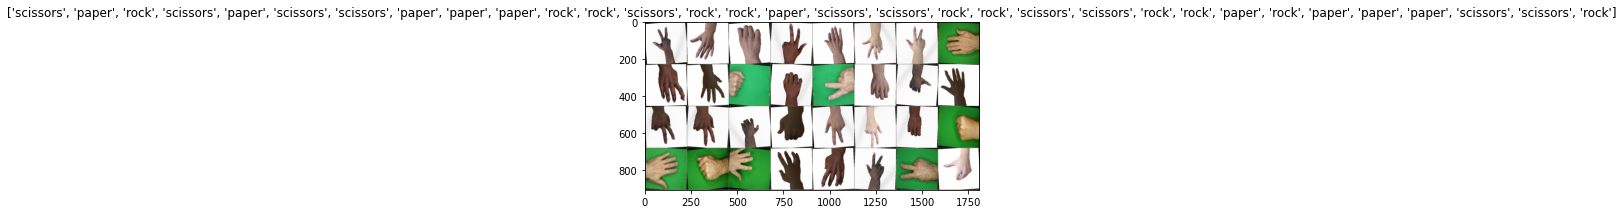

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose([1, 2, 0])
    std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.485, 0.456, 0.406])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

labels_names = ["scissors", "rock", "paper"]
imgs, labels = next(iter(train_loader))

out = torchvision.utils.make_grid(imgs)

imshow(out, title=[labels_names[x] for x in labels])

In [8]:
# net = CustomCNN().to(device)

# # vgg
# net = models.vgg11(pretrained=True).to(device)
# net.classifier[6] = nn.Linear(4096, 3)

# resnet
net = models.resnet18(pretrained=True).to(device)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 3) # rock, scissors, paper (3 labels)

model = net.to(device)

In [9]:
# loss_function, optimizer scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
lr_sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
def train(num_epochs, model, data_loader, criterion, optimizer, val_every, save_dir, device):
    print("Start training ---- !!!")
    best_loss = 9999

    train_start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        for i, (imgs, labs) in enumerate(data_loader):
            images, labels = imgs.to(device), labs.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # lr_sheduler.step()
            
            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()

            if (i + 1) % 3 == 0:
                print("Epoch [{}/{}], step [{}/{}], loss: {:.4f}, Accuracy: {:.2f}%"
                .format(epoch + 1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

        #print(optimizer.state_dict()['param_groups'][0]['lr'])
        lr_sheduler.step()

        epoch_end_time = time.time()
        print("epoch_time : {}m {}s".format(int((epoch_end_time - epoch_start_time) / 60), int((epoch_end_time - epoch_start_time) % 60)))
        print("----" * 15)

        if (epoch + 1) % val_every == 0:
            avg_loss = validation(epoch + 1, model, val_loader, criterion, device)

            if avg_loss < best_loss:
                print("Best performance at epoch: {}".format(epoch + 1))
                print("Previous loss: {:.4f}".format(best_loss))
                print("Now loss: {:.4f}".format(avg_loss))
                print("Save model in:", save_dir)
                best_loss = avg_loss
                save_model(model, save_dir)
            print("----" * 15)

    train_end_time = time.time()
    print("training_time : {}m {}s".format(int((train_end_time - train_start_time) / 60), int((train_end_time - train_start_time) % 60)))

In [11]:
def test(model, data_loader, device):
  print("Start Test")

  correct = 0
  total = 0
  with torch.no_grad():
    for i, (imgs, labs) in enumerate(data_loader):
      images, labels = imgs.to(device), labs.to(device)

      outputs = model(images)
      _, argmax = torch.max(outputs, 1)
      total += images.size(0)
      correct += (labels == argmax).sum().item()

    print("Test Accuracy for {} images: {:.2f}%".format(total, correct / total * 100))

In [12]:
def validation(epoch, model, data_loader, criterion, device):
  print("Start val")
  model.eval()

  with torch.no_grad():
    total = 0
    correct = 0
    total_loss = 0
    cnt = 0

    for i, (imgs, labs) in enumerate(data_loader):
      images, labels = imgs.to(device), labs.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      total += imgs.size(0)
      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax).float().mean()

      correct += (labels == argmax).sum().item()
      total_loss += loss
      cnt += 1

    avg_loss = total_loss / cnt
    print("Validation #{} Accuracy {:.2f}% Average Loss: {:.4f}".format(epoch, correct / total * 100, avg_loss))

  model.train()
  return avg_loss

In [13]:
# save model
def save_model(model, save_dir, file_name = "best_model.pt"):
  os.makedirs(save_dir, exist_ok=True)
  output_path = os.path.join(save_dir, file_name)
  torch.save(model.state_dict(), output_path)

In [14]:
save_dir = "./weights/"
val_every = 1

load_model = 1  # 0 == False

if load_model == 1:
    model_loader_path = "weights/best_model_resnet_70per.pt"
    model.load_state_dict(torch.load(model_loader_path))

train_mode = 0 if load_model == 1 else 1  # 0 == False

if train_mode == 1:
    model.train()
    train(num_epochs, model, train_loader, criterion, optimizer, val_every, save_dir, device)
else:
    model.eval()
    test(model, custom_test_loader, device)

Start Test
Test Accuracy for 224 images: 70.54%


In [15]:
def image_path_loader(image_name, device):
    loader = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(image_name)
    img = img.convert("RGB") # image BGR -> RGB convert
    img = loader(img)
    img = torch.unsqueeze(img, 0)
    return img.to(device)

def image_loader(image, device):
    loader = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = image.convert("RGB") # image BGR -> RGB convert
    image = loader(image)
    image = torch.unsqueeze(image, 0)
    return image.to(device)

In [16]:
#0이면 노트북 내장 웹캠 숫자를 올리면 추가된 웹캠을 이용
cap = cv2.VideoCapture(0)

# 3 = height, 4 = width
cap.set(3, 720)
cap.set(4, 1080)

# img = image_loader("rsp/test/rock/testrock01-00.png", device)

# outputs = model(img)
# _, argmax = torch.max(outputs, 1)
# m = nn.Softmax(dim=1)
# print(m(outputs)[0][1].item())

class_names = ["scissors", "rock", "paper"]
m = nn.Softmax(dim=1)
# print(class_names[argmax])

while True:
    ret, frame = cap.read()
    image_copy = Image.fromarray(frame)
    input_img = image_loader(image_copy, device)

    outputs = model(input_img)

    _, argmax = torch.max(outputs, 1)
    # print(m(outputs)[0][argmax].item())
    text = str(round(m(outputs)[0][argmax].item() * 100, 2)) + " %"

    frame = cv2.putText(frame, class_names[argmax], (2, 20), 0, 1, (0, 255, 0), 2)
    frame = cv2.putText(frame, text, (150, 20), 0, 0.5, (255, 0, 0), 2)
    cv2.imshow('test', frame)
    k = cv2.waitKey(1)
    if k == 27: # esc # ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute '__array_interface__'